In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


import scipy.integrate as integrate
import scipy.io as sio
#from Lorenz96_RK4 import Lorenz96
import sys, os, time, datetime
import pickle

from F import F
from fun_getPieces import fun_getPieces
from fun_A import fun_A
from fun_dAX import fun_dAX
from fun_dAnu import fun_dAnu

codename = 'v04'
np.set_printoptions(precision=7, linewidth=100)

In [4]:
# Data, Data Assimilation Hyperparameters
D = 20
Dobs = 8
dims = set(np.arange(20))
#dim_obs = [1, 2, 3, 5, 7, 9, 11, 13, 15, 17, 18, 19]
# dim_obs = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16, 17, 18]
dim_obs = [0, 3, 6, 8, 10, 12, 15, 18]
dim_unobs = list(dims - set(dim_obs))
M = 200

# Annealing Hyperparameters
Rm = float(1)
Rf0 = 1e-1
alpha = 1.3
betamax = 100


# Hamiltonian Monte Carlo Hyperparameters
niter_list = [1e3]*90 + [1e2]*10
# niter_list = [1e3]*betamax
niter = np.array(niter_list).astype(int)

# Te = np.exp(1e-1*np.arange(niter))  # Temperature
epsilon_list = [1e-2]*20 + [1e-3]*32 + [1e-4]*36 + [1e-5]*12
# epsilon_list = [1e-2]*betamax
epsilon = np.array(epsilon_list)

L = np.array([150]*20 + [50]*80)
# L = np.array([150]*betamax)

# mass = [1e2, 1e-2, 1e0]
ones = np.ones(3)
multiply = [1, 10, 100, 10]
times = [52, 20, 16, 12]
mass = np.array([list(ones * mult) for mult, t in zip(multiply, times) for i in range(t)])
# mass = np.array([list(ones*10) for i in range(betamax)])

# Scaling of the actionand its gradients
scaling = np.array([1e6]*100)
# scaling = np.array([1e6]*betamax)

In [5]:
# Each element in niter/nblocks must be an integer
nblocks = 10
# Determine the percentage of samples used to calculate X_avg for each beta
parts = np.floor(nblocks/2)

# Switch for plotting Action vs. beta at the end. Another can be found at 
# the end of the program for plotting action vs. iteration in a chosen beta
plot_action_vs_beta = 1

# Switch for saving data at the end
savedata = 0

In [6]:
# Load the data set
gen_nu = "8.17"
gen_noise = "sig0.4"
gen_dt = "0.025"
gen_delta_t = "0.025"
gen_integrator = "trapez"

# Specify the data path
datapath = ("./L96_D%s_nu%s_%s_dt%s_deltat%s_%s.mat" % 
    (str(D), gen_nu, gen_noise, gen_dt, gen_delta_t, gen_integrator))

if datapath[-3:] == "mat":
    datadict = sio.loadmat(datapath)
    data = datadict["Data"]
    dt = datadict["delta_t"][0]
elif datapath[-3:] == "npy":
    data = np.load(datapath)
else:
    raise IOError ("Does not recognize data file extension\n datapath = %s" % datapath)
    sys.exit()

In [7]:
# Y is the L by M matrix of observations
# Specific dimensions are chosen to be the observed dimensions
Y = data[dim_obs,:M]

# Read time interval from data
# dt = delta_t
# This is done a few lines earlier

# Sanity check, make sure all the PA hyperparameters have the same size
if (betamax != 1) and (betamax != 2):
    arrays = [niter, epsilon, L, mass, scaling]
    checklist = [item.shape[0] == betamax for item in arrays]
    if False in checklist:
        print(checklist)
        print("\n Aborted. Check precision annealing setting.")
        

In [8]:
# Maybe a list would work here to replace cell?
mass_X = []
mass_X_sqrt = []
mass_nu = np.zeros(betamax)
mass_nu_sqrt = np.zeros(betamax)
for beta in range(betamax):
    mass_X.append(np.zeros(shape=(D,M)))
    mass_X[beta][dim_obs,:] = mass[beta, 0]
    mass_X[beta][dim_unobs,:] = mass[beta,1]
    mass_nu[beta] = mass[beta,2]
    
    mass_X_sqrt.append(np.zeros(shape=(D,M)))
    mass_X_sqrt[beta][dim_obs,:] = np.sqrt(2 * mass[beta,0])
    mass_X_sqrt[beta][dim_unobs,:] = np.sqrt(2 * mass[beta,1])
    mass_nu_sqrt[beta] = np.sqrt(2* mass[beta,2])


In [9]:
# Initilize vectorized dirac delta functions
eyeDleft1 = np.roll(np.eye(D), -1, 1)
eyeDleft2 = np.roll(np.eye(D),-2,1)
eyeDright1 = np.roll(np.eye(D),1,1)
eyeD = np.eye(D)
# Some initializations for HMC

# Define the Rf ladder
Rf = Rf0 * (alpha**(np.arange(0,betamax)))
    
np.random.seed(12345)
X_init = [np.zeros(shape=(D,M)) for i in range(betamax)]
nu_init = [0 for i in range(betamax)]

nu_init[0] = 8
X_init[0][:,0] = 20*np.random.random(size=(D)) - 10
X_init[0][dim_obs,:] = Y

for k in range(1,M):
    X_init[0][:,k] = X_init[0][:,k-1] + dt*F(X_init[0][:,k-1] + dt/2*F(X_init[0][:,k-1],nu_init[0]), nu_init[0])
    X_init[0][dim_obs,k] = Y[:,k]

In [10]:
# X/nu_avg(beta) -- solutions after current beta is finished

X_avg = [np.zeros(shape=(D,M)) for beta in range(betamax)]
nu_avg = [0 for beta in range(betamax)]

# Places to store running sums of the states, with each cell an average
# of around niter/nblocks iterations
X_sum = [[np.zeros(shape=(D,M)) for j in range(nblocks)] for beta in range(betamax)]
nu_sum = [[0 for j in range(nblocks)] for beta in range(betamax)]

niter_max = max(niter)

# Save X(t_final) and nu along the way
X_f_history = [[np.zeros(shape=(D)) for j in range(niter_max)] for beta in range(betamax)]
nu_history = [[0 for j in range(niter_max)] for beta in range(betamax)]


In [11]:
#Initialize action matrix
action = np.zeros(shape=(betamax, niter_max))  #in MATLAB code, the shape is (betamax, niter_max+1). Not sure why the +1
# Initialize argmin A(X) for each beta, for reference only
action_min = np.zeros(shape=betamax)
# Initialize A(X_avg), measurement and model errors
action_avg = np.zeros(shape=betamax)
ME_avg = np.zeros(shape=betamax)
FE_avg = np.zeros(shape=betamax)
FE_avg_with_Rf = np.zeros(shape=betamax)

# Percentage acceptance and percentage downhill
Acceptance = np.zeros(shape=betamax)
Downhill = np.zeros(shape=betamax)

# Initialize Momentum
pX0 = np.zeros(shape=(D,M))

In [12]:
# Precision annealing and Hamiltonian Monte Carlo

for beta in range(betamax):
   # Initialize states (i.e. take the results from the previous step)
    X0 = X_init[beta]
    nu0 = nu_init[beta]
    
    # Evaluate the starting action under current beta
    Xu1, Xd1, Xd2, Xleft1, hX = fun_getPieces(X0, nu0, dt)

    action[beta, 0] = fun_A(X0, Xleft1, hX, dim_obs, M, Y, Rm, Rf[beta])
    action_min[beta] = action[beta, 0]
    
    # HMC kernel
    print('Start annealing for beta = %d'% beta)
    start_time = time.time()
    
    for n in range(1, niter[beta]):
        eps = epsilon[beta]
        
        # Take current states as starting points
        X, nu = X0, nu0
        
        # Generate initial momenta from a multivariate normal distribution
        pX0[dim_obs,:] = np.random.normal(0, np.sqrt(mass[beta, 0]), size=(Dobs,M))
        pX0[dim_unobs,:] = np.random.normal(0, np.sqrt(mass[beta, 1]), size=(D-Dobs, M))
        pnu0 = np.random.normal(0, np.sqrt(mass[beta, 2]))
        
        # Get necessary pieces
        Xu1, Xd1, Xd2, Xleft1, hX = fun_getPieces(X, nu, dt)
        # Half step for X momenta
        pX = pX0 - eps/2*fun_dAX(X, Xu1, Xd1, Xd2, Xleft1, hX, 
                                 eyeD, eyeDleft2, eyeDleft1, eyeDright1, 
                                 D, dim_obs, M, Y, dt, Rm, Rf[beta], scaling[beta])
        
        # Half step for the nu momentum
        pnu = pnu0 - eps/2*fun_dAnu(Xleft1, hX, M, dt, Rf[beta], scaling[beta])
        
        # Simulate Hamiltonian dynamics
        for i in range(L[beta]):
            # Full step for the state variables
            X = X + eps* np.divide(pX, mass_X[beta])
            nu = nu + eps* pnu / mass_nu[beta]
            
            # Get necessary pieces
            Xu1, Xd1, Xd2, Xleft1, hX = fun_getPieces(X, nu, dt)
            if i != L[beta]-1:
                # Full step for the X momenta except at end of trajectory
                pX = pX - eps*fun_dAX(X, Xu1, Xd1, Xd2, Xleft1, hX, 
                                 eyeD, eyeDleft2, eyeDleft1, eyeDright1, 
                                 D, dim_obs, M, Y, dt, Rm, Rf[beta], scaling[beta])
                # Full step for the nu momentum except at end of trajectory
                pnu = pnu0 - eps*fun_dAnu(Xleft1, hX, M, dt, Rf[beta], scaling[beta])

        # Half step for X momenta
        pX = pX0 - eps/2*fun_dAX(X, Xu1, Xd1, Xd2, Xleft1, hX, 
                                 eyeD, eyeDleft2, eyeDleft1, eyeDright1, 
                                 D, dim_obs, M, Y, dt, Rm, Rf[beta], scaling[beta])
        
        # Half step for the nu momentum
        pnu = pnu0 - eps/2*fun_dAnu(Xleft1, hX, M, dt, Rf[beta], scaling[beta])
        
        # Calculate action when simulation is done
        action_candidate = fun_A(X, Xleft1, hX, dim_obs, M, Y, Rm, Rf[beta])
        # Metropolis Hasings acceptance/rejection rule
        E_current = scaling[beta]*action[beta,n-1] + np.sum(np.divide(pX0, mass_X_sqrt[beta])**2) + (pnu0/mass_nu_sqrt[beta])**2
        E_proposal = scaling[beta]*action_candidate + np.sum(np.divide(pX, mass_X_sqrt[beta])**2) + (pnu/mass_nu_sqrt[beta])**2
        if np.random.uniform() < np.exp(E_current - E_proposal):
            # Accepted states and action serve as the next starting point
            X0, nu0 = X, nu
            action[beta,n] = action_candidate
            # Count acceptance rate
            Acceptance[beta] += 1
        else:
            action[beta,n] = action[beta,n-1]
        
        # Assign the running summations to their corresponding cells
        X_sum[beta][int(np.floor((n)/(niter[beta]/nblocks)))] += X0
        nu_sum[beta][int(np.floor((n)/(niter[beta]/nblocks)))] += nu0
        
        # Save X(t_final) and nu along the way
        X_f_history[beta][n-1] = X0[:,-1]
        nu_history[beta][n-1] = nu0
        
        # Check if current proposal yields the lowest action so far
        if action[beta,n] < action_min[beta]:
            # If so, update the lowest action and the corresponding states
            action_min[beta] = action[beta,n]
            # Count downhill rate
            Downhill[beta] += 1
    print('Done. Time elapsed: %d sec' % (time.time() - start_time))
    
    # -----------------
    # Solution for current beta
    for j in range(int(nblocks-parts), nblocks):
        X_avg[beta] += X_sum[beta][j]
        nu_avg[beta] += nu_sum[beta][j]
    
    X_avg[beta] /= niter[beta] / nblocks * parts
    nu_avg[beta] /= niter[beta] / nblocks * parts
    
    # Final action for current beta
    _, _, _, Xleft1, hX = fun_getPieces(X_avg[beta], nu_avg[beta], dt)
    action_avg[beta] = fun_A(X_avg[beta], Xleft1, hX, dim_obs, M, Y, Rm, Rf[beta])
    
    # Measurement and model error for current beta
    ME_avg[beta] = 0.5 / M * np.sum((X_avg[beta][dim_obs,:] - Y)**2)
    temp = Xleft1 - hX
    FE_avg[beta] = 0.5 / M * np.sum((temp[:,:-2])**2)
    FE_avg_with_Rf[beta] = FE_avg[beta] * Rf[beta]
    
    # Starting point for the next beta
    if beta != betamax-1:
        X_init[beta+1] = X_avg[beta]
        nu_init[beta+1] = nu_avg[beta]
        
    # Finalize the percentages
    Acceptance[beta] /= niter[beta]
    Downhill[beta] /= niter[beta]

print('\n')

Start annealing for beta = 0


c:\python27\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: overflow encountered in exp


Done. Time elapsed: 237 sec
Start annealing for beta = 1
Done. Time elapsed: 222 sec
Start annealing for beta = 2
Done. Time elapsed: 222 sec
Start annealing for beta = 3
Done. Time elapsed: 224 sec
Start annealing for beta = 4
Done. Time elapsed: 234 sec
Start annealing for beta = 5
Done. Time elapsed: 240 sec
Start annealing for beta = 6
Done. Time elapsed: 242 sec
Start annealing for beta = 7
Done. Time elapsed: 246 sec
Start annealing for beta = 8
Done. Time elapsed: 244 sec
Start annealing for beta = 9
Done. Time elapsed: 243 sec
Start annealing for beta = 10
Done. Time elapsed: 224 sec
Start annealing for beta = 11


fun_dAX.py:9: RuntimeWarning: overflow encountered in multiply
  kern2 = np.multiply(np.transpose(X[:,:,None] - np.roll(hX, 1, 1)[:,:,None], (0, 2, 1)), eyeD[:,:,None] - dt/2*GX)
c:\python27\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
fun_dAX.py:13: RuntimeWarning: overflow encountered in multiply
  kern3 = np.multiply(np.transpose(Xleft1[:,:,None]-hX[:,:,None], (0,2,1)), eyeD[:,:,None] + dt/2*GX)
fun_dAX.py:20: RuntimeWarning: invalid value encountered in add
  dAX = scaling * (kern1 + kern2 + kern3)
fun_dAX.py:20: RuntimeWarning: overflow encountered in multiply
  dAX = scaling * (kern1 + kern2 + kern3)
fun_getPieces.py:14: RuntimeWarning: invalid value encountered in subtract
  hX = (X + dt/2*(np.multiply(Xu1 - Xd2, Xd1) - X + nu) +
fun_getPieces.py:14: RuntimeWarning: overflow encountered in multiply
  hX = (X + dt/2*(np.multiply(Xu1 - Xd2, Xd1) - X + nu) +
fun_getPiec

Done. Time elapsed: 221 sec
Start annealing for beta = 12
Done. Time elapsed: 222 sec
Start annealing for beta = 13
Done. Time elapsed: 220 sec
Start annealing for beta = 14
Done. Time elapsed: 221 sec
Start annealing for beta = 15
Done. Time elapsed: 207 sec
Start annealing for beta = 16
Done. Time elapsed: 242 sec
Start annealing for beta = 17
Done. Time elapsed: 235 sec
Start annealing for beta = 18
Done. Time elapsed: 239 sec
Start annealing for beta = 19
Done. Time elapsed: 236 sec
Start annealing for beta = 20
Done. Time elapsed: 79 sec
Start annealing for beta = 21
Done. Time elapsed: 80 sec
Start annealing for beta = 22
Done. Time elapsed: 79 sec
Start annealing for beta = 23
Done. Time elapsed: 78 sec
Start annealing for beta = 24
Done. Time elapsed: 81 sec
Start annealing for beta = 25
Done. Time elapsed: 80 sec
Start annealing for beta = 26
Done. Time elapsed: 79 sec
Start annealing for beta = 27
Done. Time elapsed: 79 sec
Start annealing for beta = 28
Done. Time elapsed: 82

fun_dAX.py:20: RuntimeWarning: overflow encountered in add
  dAX = scaling * (kern1 + kern2 + kern3)
fun_dAX.py:14: RuntimeWarning: overflow encountered in multiply
  kern3 = -Rf/M*np.transpose(np.sum(kern3,0)[None,:,:], (1,2,0))[:,:,0]
fun_dAX.py:10: RuntimeWarning: overflow encountered in multiply
  kern2 = Rf/M*np.transpose(np.sum(kern2,0)[None,:,:], (1,2,0))[:,:,0]


Done. Time elapsed: 78 sec
Start annealing for beta = 30
Done. Time elapsed: 78 sec
Start annealing for beta = 31
Done. Time elapsed: 81 sec
Start annealing for beta = 32
Done. Time elapsed: 75 sec
Start annealing for beta = 33
Done. Time elapsed: 88 sec
Start annealing for beta = 34
Done. Time elapsed: 92 sec
Start annealing for beta = 35
Done. Time elapsed: 92 sec
Start annealing for beta = 36
Done. Time elapsed: 92 sec
Start annealing for beta = 37
Done. Time elapsed: 91 sec
Start annealing for beta = 38
Done. Time elapsed: 91 sec
Start annealing for beta = 39
Done. Time elapsed: 91 sec
Start annealing for beta = 40
Done. Time elapsed: 90 sec
Start annealing for beta = 41
Done. Time elapsed: 93 sec
Start annealing for beta = 42
Done. Time elapsed: 95 sec
Start annealing for beta = 43
Done. Time elapsed: 96 sec
Start annealing for beta = 44
Done. Time elapsed: 92 sec
Start annealing for beta = 45
Done. Time elapsed: 93 sec
Start annealing for beta = 46
Done. Time elapsed: 92 sec
Star

In [13]:
# Save Data

if savedata == 1:
    # Note, some pieces will have incorrect indexing (e.g. dim_obs). 
    # Maybe save it in a different way (e.g. in an .npy file), otherwise, save it twice?
    date = datetime.datetime.today()
    filename = "v10_%d-%s-%d_%d" % (date.day, date.month, date.year, np.random.randint(1000,9999))
    keys = ['Acceptance', 'Action', 'Action_avg', 'Action_min', 'alpha',
            'betamax', 'codename', 'D', 'dim_obs', 'Dobs', 'Downhill', 'dt',
            'epsilon', 'FE_avg', 'FE_avg_with_Rf', 'gen_delta_t', 'gen_dt'
            'gen_integrator', 'gen_noise', 'gen_nu', 'L', 'M', 'mass', 'ME_avg', 
            'nblocks', 'niter', 'nu_avg', 'nu_history', 'nu_init', 'nu_sum',
            'parts', 'q_min', 'Rf', 'Rf0','Rm', 'scaling',
            'X_avg', 'X_f_history', 'X_init', 'X_sum', 'Y']
    values = [Acceptance, action, action_avg, action_min, alpha,
            betamax, codename, D, dim_obs, Dobs, Downhill, dt,
            epsilon, FE_avg, FE_avg_with_Rf, gen_delta_t, gen_dt,
            gen_integrator, gen_noise, gen_nu, L, M, mass, ME_avg, 
            nblocks, niter, nu_avg, nu_history, nu_init, nu_sum,
            parts, q_min, Rf, Rf0, Rm, scaling,
            X_avg, X_f_history, X_init, X_sum, Y]
    mdict = dict(zip(keys, values))
    sio.savemat(filename, mdict)



In [ ]:
print(action[15:,-5:])
# print(Rf)

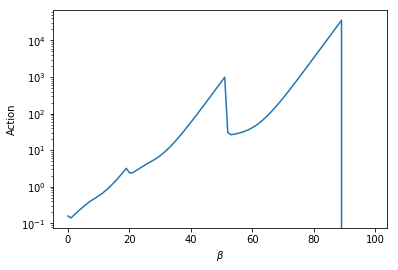

In [15]:
# Visualize the whole annealing process

if plot_action_vs_beta == 1:
    plt.figure()
    plt.plot(np.arange(betamax), action[:,-1]) # action has shape = (betamax, nitermax)
    plt.yscale('log')

    plt.ylabel('Action')
    plt.xlabel(r'$\beta$')
    plt.show()
    


D = 5
dim_obs = [0,1,2]
M = 5
# Initilize vectorized dirac delta functions
eyeDleft1 = np.roll(np.eye(D), -1, 1)
eyeDleft2 = np.roll(np.eye(D),-2,1)
eyeDright1 = np.roll(np.eye(D),1,1)
eyeD = np.eye(D)

Rf0 = 1e6
Y = data[dim_obs, :M]
X = np.arange(1,26).reshape(5,5).transpose()
nu = 8
dt = 0.01

Xu1, Xd1, Xd2, Xleft1, hX = fun_getPieces(X, nu, dt)
kern2 = fun_dAX(X, Xu1, Xd1, Xd2, Xleft1, hX, eyeD, eyeDleft2, eyeDleft1, eyeDright1, D, dim_obs, M, Y, dt, Rm, Rf0, 1)